In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [2]:
#the excelbook had two sheets so I had to save them individually
df1 = pd.read_csv('online_retail_2010-2011.csv')
df2 = pd.read_csv('online_retail_2009-2010.csv')

In [3]:
#combine both years
data = pd.concat([df1, df2], ignore_index=True)

In [4]:
#delete duplicate rows
data = data.drop_duplicates()

#sometimes quantity and price are weird
#data = data[(data["Quantity"] >= 0) & (data["Price"] > 0)]
#nevermind don't do this. cancelled transactions are stored like this


data["Quantity"] = data["Quantity"].abs() 
data["Price"] = data["Price"].abs()

In [5]:
#check to see if deleting rows with missing data is viable

initial_row_count = len(data)
print(f"Initial number of rows: {initial_row_count}")

# Drop rows with any missing data
data_cleaned = data.dropna()


final_row_count = len(data_cleaned)
print(f"Number of rows after removing rows with empty data: {final_row_count}")

Initial number of rows: 1033036
Number of rows after removing rows with empty data: 797885


In [6]:
missing_counts = data.isnull().sum()
missing_percentages = (missing_counts / len(data)) * 100
missing_summary = pd.DataFrame({
    'Missing Values': missing_counts,
    'Percentage (%)': missing_percentages
})
missing_summary_sorted = missing_summary.sort_values(by='Missing Values', ascending=False)
print(missing_summary_sorted)

             Missing Values  Percentage (%)
Customer ID          235151       22.763098
Description            4275        0.413829
Invoice                   0        0.000000
StockCode                 0        0.000000
Quantity                  0        0.000000
InvoiceDate               0        0.000000
Price                     0        0.000000
Country                   0        0.000000


In [7]:
#The VAST majority of the missing data is in the customer ID column. This means it is probably best to have two dataframes. One with cleanedrows for where customer ID is crucial and one without where customer ID doesn't matter

In [8]:
#Since none of the following graphs involve Costumer ID at all we can rely on the larger dataset.
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%m/%d/%Y %H:%M')
print(data['InvoiceDate'].head())

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]


In [9]:
data['Hour'] = data['InvoiceDate'].dt.hour
data['DayOfWeek'] = data['InvoiceDate'].dt.day_name()
data['Month'] = data['InvoiceDate'].dt.month

data['Revenue'] = data['Quantity'] * data['Price']

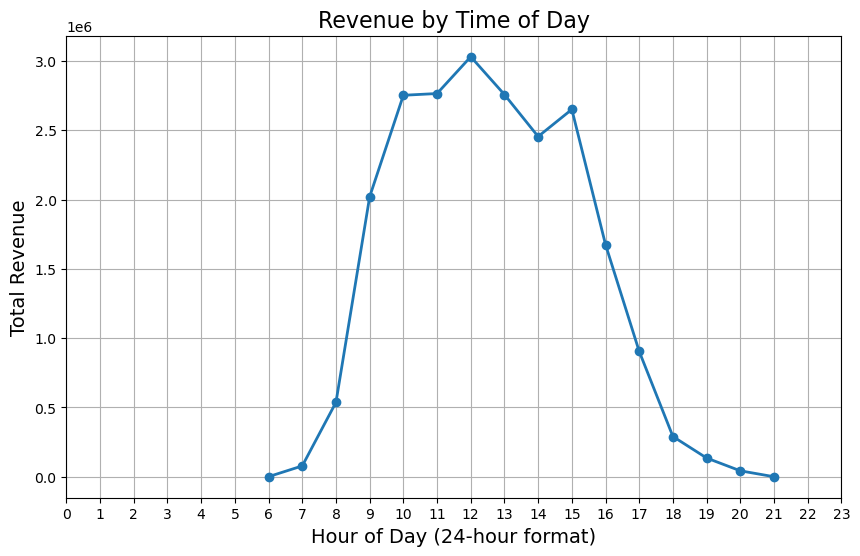

In [10]:
time_of_day_revenue = data.groupby('Hour')['Revenue'].sum()
plt.figure(figsize=(10, 6))
plt.plot(time_of_day_revenue.index, time_of_day_revenue.values, marker='o', linestyle='-', linewidth=2)
plt.title('Revenue by Time of Day', fontsize=16)
plt.xlabel('Hour of Day (24-hour format)', fontsize=14)
plt.ylabel('Total Revenue', fontsize=14)
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

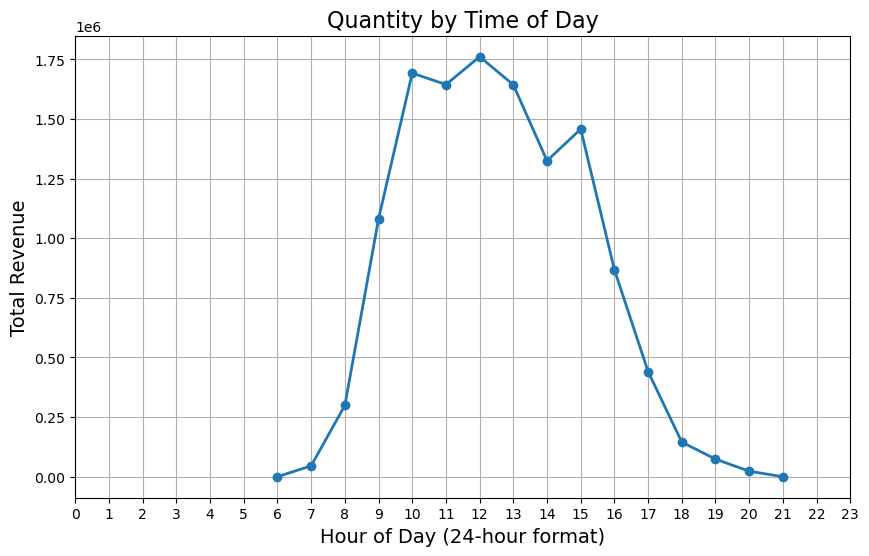

In [11]:
time_of_day_revenue = data.groupby('Hour')['Quantity'].sum()
plt.figure(figsize=(10, 6))
plt.plot(time_of_day_revenue.index, time_of_day_revenue.values, marker='o', linestyle='-', linewidth=2)
plt.title('Quantity by Time of Day', fontsize=16)
plt.xlabel('Hour of Day (24-hour format)', fontsize=14)
plt.ylabel('Total Revenue', fontsize=14)
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

In [12]:
#These results clearly show us that quantity of items bought and revenue to the store are fairly linked. This also shows us that the amount of both have a bell-esque curve peaking at noon.
#Interestingly, this data also shows us the opening and closing times of the store. Namely 6 am and closing at 9 pm. This is strange as the data is said to come from an online store

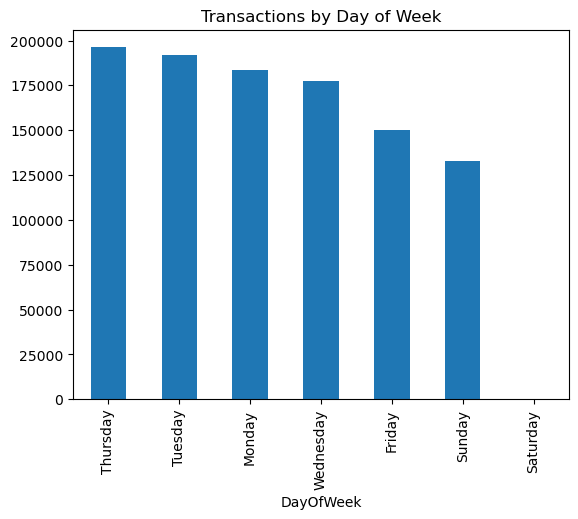

In [13]:
data['DayOfWeek'].value_counts().plot(kind='bar', title='Transactions by Day of Week')
plt.show()

In [14]:
#It seems as though people like to buy earlier in the week. Strangly there is no data on Saturday despite the data coming from an online store.

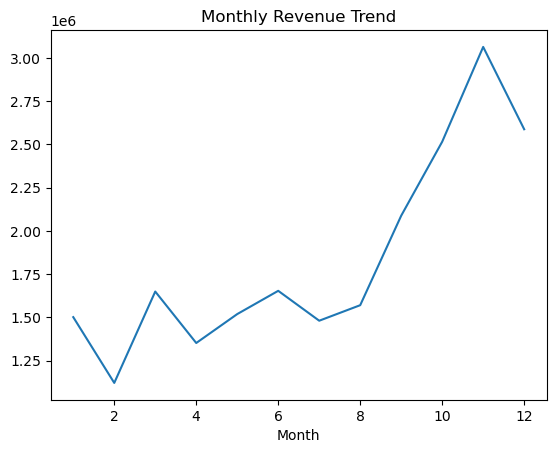

In [15]:
data.groupby('Month')['Revenue'].sum().plot(kind='line', title='Monthly Revenue Trend')
plt.show()

In [16]:
#as could be predicted the amount of purchases heavily spikes around holiday time. You can clearly see a massive spike in November. This could possibly be black friday sales.

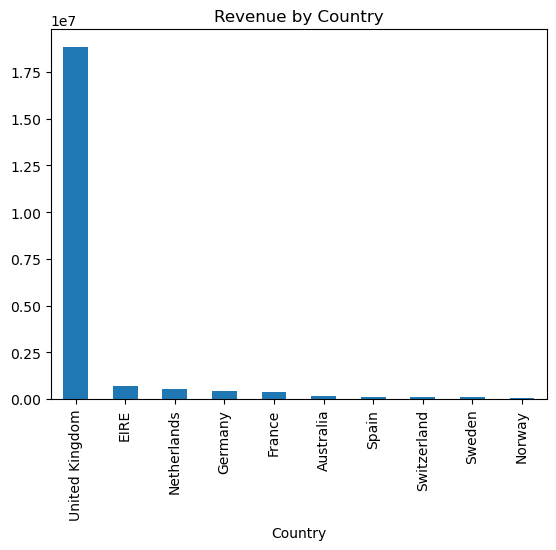

In [17]:
data.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10).plot(kind='bar', title='Revenue by Country')
plt.show()

In [18]:
#also to be expected is the dominance of UK sales. This makes sense as the company is based within the United Kingdom

In [19]:
#TASK 2: Customer Segentation

In [20]:
print(data_cleaned.columns)

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


In [21]:
data_cleaned = data.dropna()

# Group data by 'CustomerID' and aggregate purchase data. Since this requires customer ID we must use the Data cleaned data frame.
customer_data = data_cleaned.groupby('Customer ID').agg(
    total_revenue=('Revenue', 'sum'),
    purchase_count=('Invoice', 'nunique'),
    avg_transaction_size=('Revenue', 'mean'),
    last_purchase_date=('InvoiceDate', 'max'),
    product_diversity=('StockCode', 'nunique')
)

# Create recency feature (days since last purchase)
customer_data['recency'] = (data_cleaned['InvoiceDate'].max() - customer_data['last_purchase_date']).dt.days
customer_data = customer_data.drop(columns=['last_purchase_date'])  # Drop the date column as we now have recency

In [22]:
features = ['total_revenue', 'purchase_count', 'avg_transaction_size', 'recency', 'product_diversity']

scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[features])

customer_data_scaled = pd.DataFrame(customer_data_scaled, columns=features, index=customer_data.index)

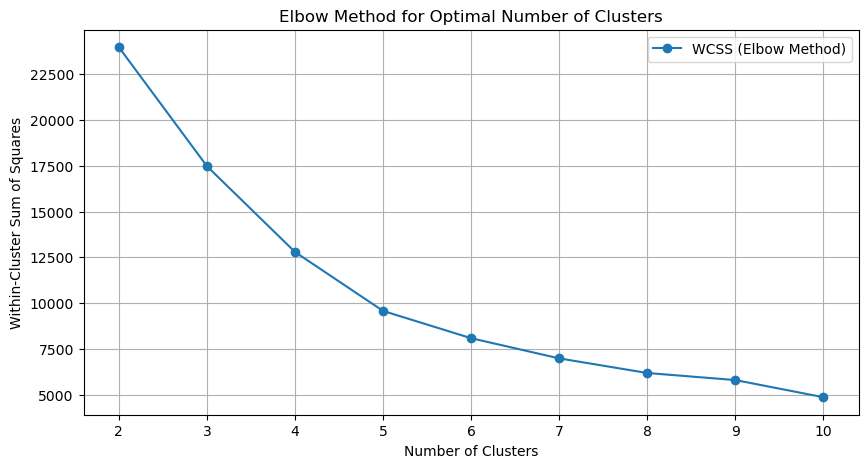

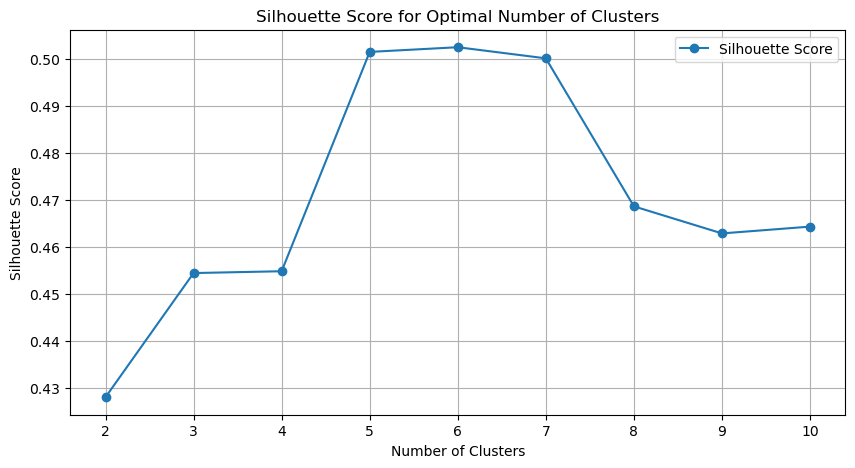

In [23]:
from sklearn.metrics import silhouette_score

range_n_clusters = range(2, 11)
wcss = []  # Within-Cluster Sum of Squares for the Elbow Method
silhouette_scores = []  # Silhouette scores for each cluster count

for n_clusters in range_n_clusters:
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(customer_data_scaled)
    
    # Append WCSS
    wcss.append(kmeans.inertia_)
    
    # Calculate the silhouette score and append it
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(customer_data_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, wcss, marker='o', label='WCSS (Elbow Method)')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid()
plt.legend()
plt.show()

# Plot Silhouette Score
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o', label='Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.grid()
plt.legend()
plt.show()

In [24]:
#This data suggests that 5 clusters is pretty good

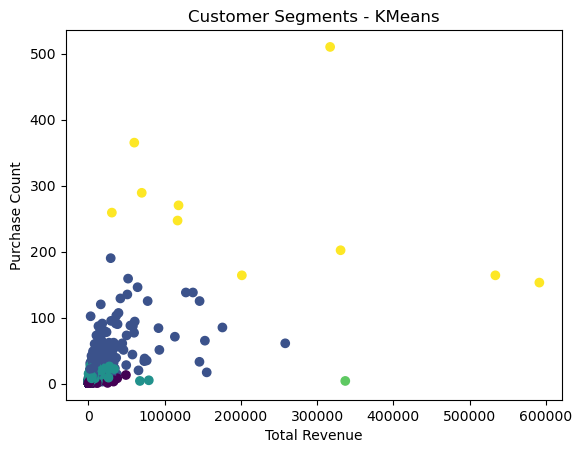

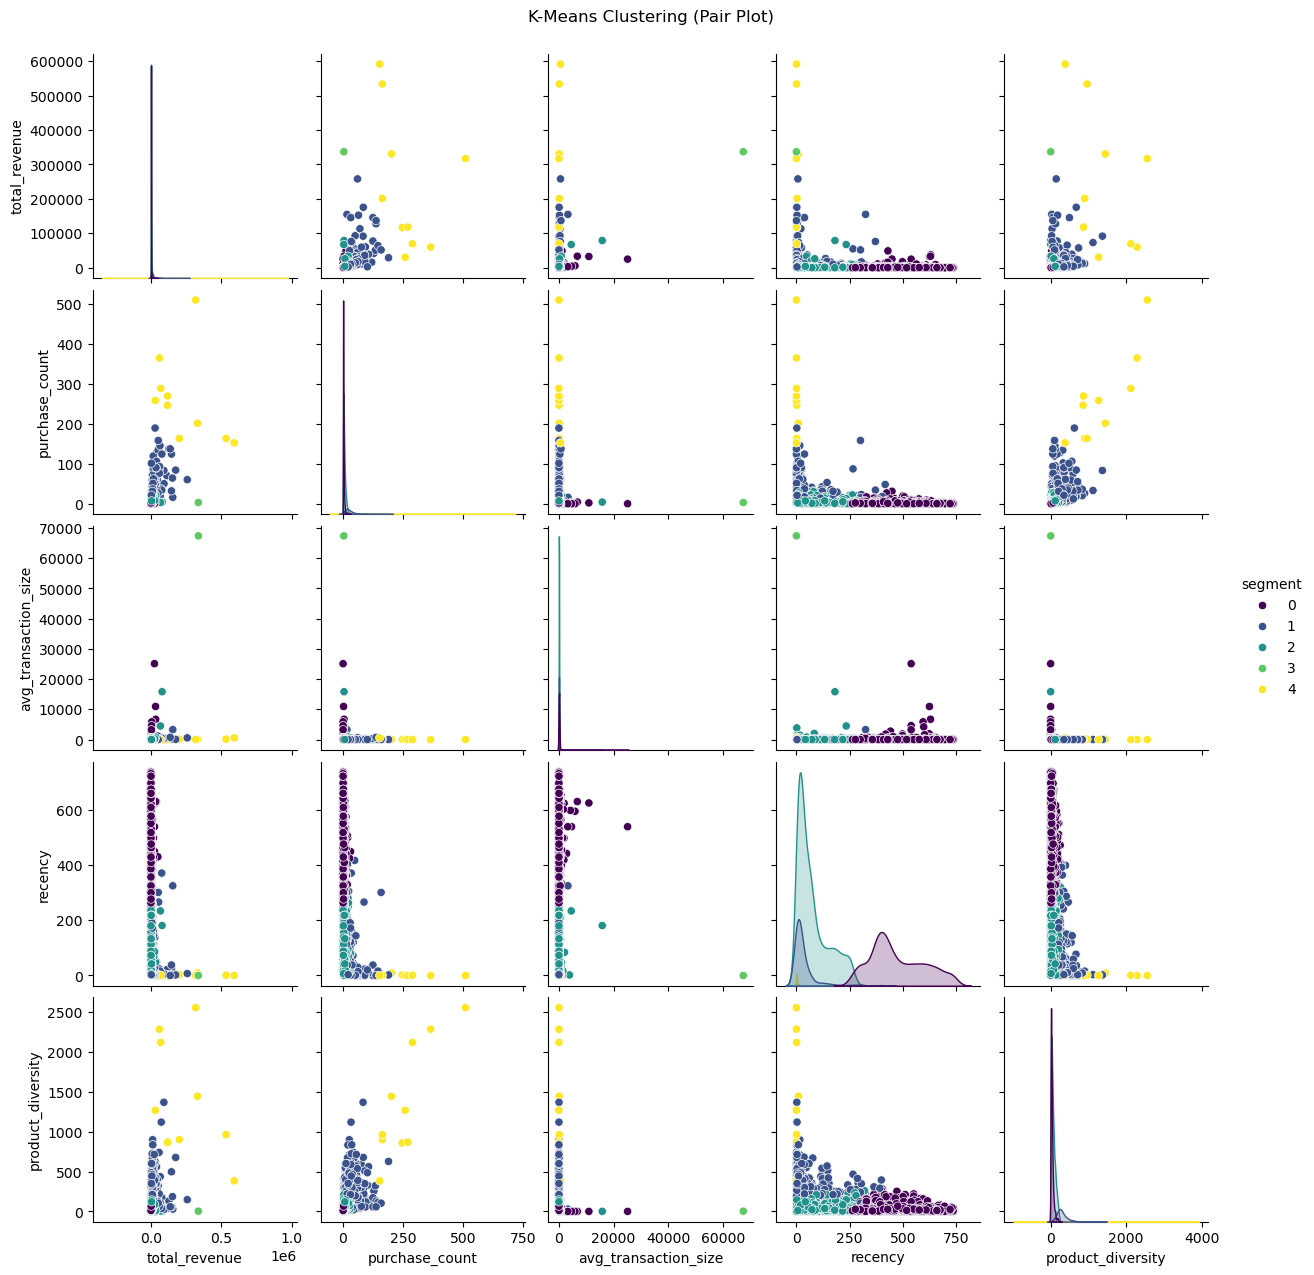

In [25]:
kmeans = KMeans(n_clusters=5, random_state=42)
customer_data['segment'] = kmeans.fit_predict(customer_data_scaled)

plt.scatter(customer_data['total_revenue'], customer_data['purchase_count'], c=customer_data['segment'], cmap='viridis')
plt.xlabel('Total Revenue')
plt.ylabel('Purchase Count')
plt.title('Customer Segments - KMeans')
plt.show()

sns.pairplot(customer_data, vars=features, hue='segment', palette='viridis')
plt.suptitle('K-Means Clustering (Pair Plot)', y=1.02)
plt.show()

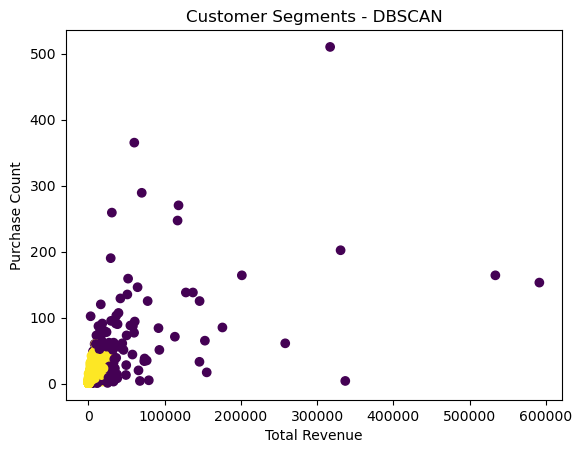

In [26]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
customer_data['segment'] = dbscan.fit_predict(customer_data_scaled)

plt.scatter(customer_data['total_revenue'], customer_data['purchase_count'], c=customer_data['segment'], cmap='viridis')
plt.xlabel('Total Revenue')
plt.ylabel('Purchase Count')
plt.title('Customer Segments - DBSCAN')
plt.show()

In [27]:
noise_points = (customer_data['segment'] == -1).sum()
print(f'Number of noise points: {noise_points}')

Number of noise points: 172


In [28]:
segment_marketing = {
    0: 'Offer exclusive deals or loyalty rewards to high-value customers.',
    1: 'Provide discounts on bulk purchases for frequent shoppers.',
    2: 'Suggest personalized products or offer welcome-back promotions.',
    3: 'Target these customers with high-value promotions.',
    4: 'Send targeted offers for new products based on browsing behavior.',
}

customer_data['marketing_strategy'] = customer_data['segment'].map(segment_marketing)
print(customer_data[['segment', 'marketing_strategy']].head())

             segment                                 marketing_strategy
Customer ID                                                            
12346.0           -1                                                NaN
12347.0            0  Offer exclusive deals or loyalty rewards to hi...
12348.0            0  Offer exclusive deals or loyalty rewards to hi...
12349.0            0  Offer exclusive deals or loyalty rewards to hi...
12350.0            0  Offer exclusive deals or loyalty rewards to hi...


In [29]:
customer_data = customer_data.merge(data[['Customer ID', 'InvoiceDate']], on='Customer ID', how='left')

customer_data['hour'] = customer_data['InvoiceDate'].dt.hour
customer_data['day_of_week'] = customer_data['InvoiceDate'].dt.dayofweek

In [30]:
communication_times = customer_data.groupby('segment').agg(
    most_common_hour=('hour', lambda x: x.mode()[0]),
    most_common_day=('day_of_week', lambda x: x.mode()[0])
)

communication_times['most_common_day'] = communication_times['most_common_day'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})

print(communication_times)

         most_common_hour most_common_day
segment                                  
-1                     12        Thursday
 0                     12        Thursday


In [31]:
# Task 3: Customer Purchase Prediction

In [32]:
#This section will heavily rely on customer ID and as such will use the cleaned database
#Check to see if customer ID is unique to a session
data_cleaned['Date'] = data_cleaned['InvoiceDate'].dt.date
customer_sessions = data_cleaned.groupby('Customer ID')['Date'].nunique().reset_index()
multiple_sessions = customer_sessions[customer_sessions['Date'] > 1]
if not multiple_sessions.empty:
    print("Customers with multiple sessions on different days:")
    print(multiple_sessions)
else:
    print("No customers have multiple sessions on different days.")

C:\Users\danie\AppData\Local\Temp\ipykernel_20796\3662234673.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Date'] = data_cleaned['InvoiceDate'].dt.date


Customers with multiple sessions on different days:
      Customer ID  Date
0         12346.0    11
1         12347.0     8
2         12348.0     5
3         12349.0     5
6         12352.0     9
...           ...   ...
5936      18282.0     3
5937      18283.0    19
5938      18284.0     2
5940      18286.0     3
5941      18287.0     7

[4398 rows x 2 columns]


In [33]:
#Website states all invoice numbers starting with C means it was cancelled
data_cleaned['IsCancellation'] = data_cleaned['Invoice'].str.startswith('C').astype(int)
print(data_cleaned['IsCancellation'].head)
print(data_cleaned['Invoice'].head(20))

<bound method NDFrame.head of 0          0
1          0
2          0
3          0
4          0
          ..
1044843    0
1044844    0
1044845    0
1044846    0
1044847    0
Name: IsCancellation, Length: 797885, dtype: int32>
0     536365
1     536365
2     536365
3     536365
4     536365
5     536365
6     536365
7     536366
8     536366
9     536368
10    536368
11    536368
12    536368
13    536367
14    536367
15    536367
16    536367
17    536367
18    536367
19    536367
Name: Invoice, dtype: object


C:\Users\danie\AppData\Local\Temp\ipykernel_20796\3563834409.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['IsCancellation'] = data_cleaned['Invoice'].str.startswith('C').astype(int)


In [34]:
#turn all invoices into one data point to represent a session or one online cart
invoice_summary = data_cleaned.groupby('Invoice').agg(
    CustomerID=('Customer ID', 'first'),
    Cancel=('IsCancellation', 'first'),
    InvoiceDate=('InvoiceDate', 'first'),
    TotalQuantity=('Quantity', 'sum'),
    TotalPrice=('Revenue', 'sum'),
    UniqueProducts=('StockCode', list),
    AveragePricePerItem=('Price', 'mean'),
    CartDiversity=('Description', 'nunique')
).reset_index()

In [35]:
print(invoice_summary.head())

  Invoice  CustomerID  Cancel         InvoiceDate  TotalQuantity  TotalPrice  \
0  489434     13085.0       0 2009-12-01 07:45:00            166      505.30   
1  489435     13085.0       0 2009-12-01 07:46:00             60      145.80   
2  489436     13078.0       0 2009-12-01 09:06:00            193      630.33   
3  489437     15362.0       0 2009-12-01 09:08:00            145      310.75   
4  489438     18102.0       0 2009-12-01 09:24:00            826     2286.24   

                                      UniqueProducts  AveragePricePerItem  \
0  [85048, 79323P, 79323W, 22041, 21232, 22064, 2...             4.081250   
1                       [22350, 22349, 22195, 22353]             2.625000   
2  [48173C, 21755, 21754, 84879, 22119, 22142, 22...             3.730526   
3  [22143, 22145, 22130, 21364, 21360, 21351, 213...             3.628261   
4  [21329, 21252, 21100, 21033, 20711, 21410, 214...             2.591176   

   CartDiversity  
0              8  
1              4  

In [36]:
#calculate the time spent by proxy. we will connect nearby transactions
invoice_summary = invoice_summary.sort_values(by=['CustomerID', 'InvoiceDate'])
invoice_summary['TimeGap'] = invoice_summary.groupby('CustomerID')['InvoiceDate'].diff().dt.total_seconds() / 60  # Convert seconds to minutes
# Fill NaN gaps (first transaction for each customer) with 0
invoice_summary['TimeGap'] = invoice_summary['TimeGap'].fillna(0)
print(invoice_summary)

      Invoice  CustomerID  Cancel         InvoiceDate  TotalQuantity  \
1006   491725     12346.0       0 2009-12-14 08:34:00             10   
1017   491742     12346.0       0 2009-12-14 11:00:00              5   
1019   491744     12346.0       0 2009-12-14 11:02:00              5   
1361   492718     12346.0       0 2009-12-18 10:47:00              5   
1363   492722     12346.0       0 2009-12-18 10:55:00              1   
...       ...         ...     ...                 ...            ...   
13000  523290     18287.0       0 2010-09-21 12:19:00             12   
17603  534346     18287.0       0 2010-11-22 11:51:00            187   
25413  554065     18287.0       0 2011-05-22 10:39:00            488   
32299  570715     18287.0       0 2011-10-12 10:23:00            990   
33328  573167     18287.0       0 2011-10-28 09:29:00            108   

       TotalPrice                                     UniqueProducts  \
1006        45.00                                          [TES

In [37]:
# Reset time spent when the gap exceeds the upper clip value
def reset_time_spent(gaps, clip):
    accumulated_time = 0
    time_spent = []

    for gap in gaps:
        if gap > clip:
            # Reset time spent if the gap exceeds the clip
            accumulated_time = 0
        else:
            # Accumulate time within the clip
            accumulated_time += gap
        time_spent.append(accumulated_time)
    return time_spent

# Apply the function to compute time spent for each transaction
invoice_summary['TimeSpent'] = invoice_summary.groupby('CustomerID')['TimeGap'].transform(
    lambda x: reset_time_spent(x, 30)
)
print(invoice_summary)

      Invoice  CustomerID  Cancel         InvoiceDate  TotalQuantity  \
1006   491725     12346.0       0 2009-12-14 08:34:00             10   
1017   491742     12346.0       0 2009-12-14 11:00:00              5   
1019   491744     12346.0       0 2009-12-14 11:02:00              5   
1361   492718     12346.0       0 2009-12-18 10:47:00              5   
1363   492722     12346.0       0 2009-12-18 10:55:00              1   
...       ...         ...     ...                 ...            ...   
13000  523290     18287.0       0 2010-09-21 12:19:00             12   
17603  534346     18287.0       0 2010-11-22 11:51:00            187   
25413  554065     18287.0       0 2011-05-22 10:39:00            488   
32299  570715     18287.0       0 2011-10-12 10:23:00            990   
33328  573167     18287.0       0 2011-10-28 09:29:00            108   

       TotalPrice                                     UniqueProducts  \
1006        45.00                                          [TES

In [38]:
invoice_summary = invoice_summary.sort_values(by=['CustomerID', 'InvoiceDate'])
invoice_summary['PreviousProducts'] = None

In [39]:
# Function to accumulate previous products for each transaction
def accumulate_previous_products(group):
    previous_products = []  # Initialize an empty list for previous products
    result = []
    for index, row in group.iterrows():
        # Assign the current previous_products to the new column
        current_previous_products = previous_products.copy()  # Create a copy to avoid overwriting
        result.append(current_previous_products)
        
        # Add the current transaction's UniqueProducts to the previous products list
        previous_products.extend(row['UniqueProducts'])
        previous_products = list(set(previous_products))  # Keep unique StockCodes
    group['PreviousProducts'] = result
    return group

# Apply the function to each customer's transaction group
invoice_summary = invoice_summary.groupby('CustomerID', group_keys=False).apply(accumulate_previous_products)

C:\Users\danie\AppData\Local\Temp\ipykernel_20796\496561736.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  invoice_summary = invoice_summary.groupby('CustomerID', group_keys=False).apply(accumulate_previous_products)


In [40]:
print(invoice_summary[['CustomerID', 'InvoiceDate', 'UniqueProducts', 'PreviousProducts']])

       CustomerID         InvoiceDate  \
1006      12346.0 2009-12-14 08:34:00   
1017      12346.0 2009-12-14 11:00:00   
1019      12346.0 2009-12-14 11:02:00   
1361      12346.0 2009-12-18 10:47:00   
1363      12346.0 2009-12-18 10:55:00   
...           ...                 ...   
13000     18287.0 2010-09-21 12:19:00   
17603     18287.0 2010-11-22 11:51:00   
25413     18287.0 2011-05-22 10:39:00   
32299     18287.0 2011-10-12 10:23:00   
33328     18287.0 2011-10-28 09:29:00   

                                          UniqueProducts  \
1006                                           [TEST001]   
1017                                           [TEST001]   
1019                                           [TEST001]   
1361                                           [TEST001]   
1363                                           [TEST002]   
...                                                  ...   
13000                                     [22642, 22639]   
17603  [21484, 84029E, 2148

In [41]:
print(invoice_summary.columns)

Index(['Invoice', 'CustomerID', 'Cancel', 'InvoiceDate', 'TotalQuantity',
       'TotalPrice', 'UniqueProducts', 'AveragePricePerItem', 'CartDiversity',
       'TimeGap', 'TimeSpent', 'PreviousProducts'],
      dtype='object')


In [42]:
from sklearn.preprocessing import MultiLabelBinarizer

#classification can't handle columns with lists
mlb = MultiLabelBinarizer()
encoded = pd.DataFrame(mlb.fit_transform(invoice_summary['UniqueProducts']), columns=mlb.classes_, index=invoice_summary.index)
invoice_summary = pd.concat([invoice_summary, encoded], axis=1)

mlb = MultiLabelBinarizer()
encoded = pd.DataFrame(mlb.fit_transform(invoice_summary['PreviousProducts']), columns=mlb.classes_, index=invoice_summary.index)
invoice_summary = pd.concat([invoice_summary, encoded], axis=1)

In [43]:
invoice_summary['Hour'] = invoice_summary['InvoiceDate'].dt.hour
invoice_summary['Weekday'] = invoice_summary['InvoiceDate'].dt.weekday

columns_to_drop = ['Invoice', 'InvoiceDate', 'CustomerID', 'UniqueProducts', 'PreviousProducts']  
classification = invoice_summary.drop(columns=columns_to_drop)

In [44]:
X = classification.drop('Cancel', axis=1)
y = classification['Cancel']

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Build a pipeline with scaling and a model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('classifier', LogisticRegression())  # Change to RandomForestClassifier() or another model if needed
])

In [46]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

C:\Users\danie\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
from sklearn.metrics import accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
log_reg = pipeline.named_steps['classifier']
print("Coefficients:\n", log_reg.coef_)
print("Intercept:", log_reg.intercept_)

Accuracy: 0.8725490196078431
Coefficients:
 [[ 0.23732873 -0.51481333  0.10453126 ... -0.04031382  0.48183489
  -0.17543011]]
Intercept: [-20.63161316]


In [48]:
#TASK 4

In [49]:
#customer ID's are not required for this section so we will use the larger dataset
print(data.columns)
data['Year'] = data['InvoiceDate'].dt.year
data['DayOfWeek'] = data['InvoiceDate'].dt.weekday.astype(int)

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Hour', 'DayOfWeek', 'Month',
       'Revenue'],
      dtype='object')


In [50]:
# Calculate cart-level statistics
cart_stats = data.groupby(['Invoice', 'Customer ID']).agg({
    'Quantity': 'sum',
    'Price': 'mean',
    'Revenue': 'sum',
    'DayOfWeek': 'first',
    'Month': 'first'
}).reset_index()
cart_stats.rename(columns={'Price': 'AvgPrice', 'Revenue': 'CartRevenue'}, inplace=True)
print

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [51]:
purchase_frequency = data.groupby('Customer ID')['Invoice'].nunique().reset_index()
purchase_frequency.rename(columns={'Invoice': 'PurchaseFrequency'}, inplace=True)
cart_stats = cart_stats.merge(purchase_frequency, on='Customer ID', how='left')

In [52]:
# Cut off 99th percentile and log all numbers
threshold = cart_stats['CartRevenue'].quantile(0.99)
cart_stats = cart_stats[cart_stats['CartRevenue'] <= threshold]
cart_stats['LogRevenue'] = np.log1p(cart_stats['CartRevenue'])

X = cart_stats.drop(['CartRevenue', 'Invoice'], axis=1)
y = cart_stats['CartRevenue']

In [53]:
numerical_features = ['Quantity', 'AvgPrice', 'PurchaseFrequency']
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])
X.head()

,Customer ID,Quantity,AvgPrice,DayOfWeek,Month,PurchaseFrequency,LogRevenue
0,13085.0,-0.093460,-0.063866,1,12,-0.400655,6.227129
1,13085.0,-0.437913,-0.081330,1,12,-0.400655,4.989071
2,13078.0,-0.005722,-0.068072,1,12,0.704677,6.447829
3,15362.0,-0.161701,-0.069298,1,12,-0.504686,5.742202
4,18102.0,2.051245,-0.081735,1,12,1.458903,7.735101


In [54]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')

Mean Squared Error: 49777.57
R^2 Score: 0.67


In [55]:
print(cart_stats['CartRevenue'].mean())

332.9999364575596


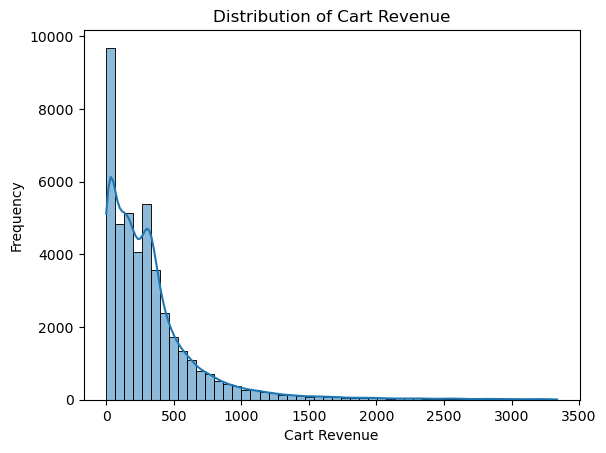

In [56]:
sns.histplot(cart_stats['CartRevenue'], bins=50, kde=True)
plt.title('Distribution of Cart Revenue')
plt.xlabel('Cart Revenue')
plt.ylabel('Frequency')
plt.show()

In [104]:
# Task 5: Product Bundling

In [106]:
from mlxtend.frequent_patterns import apriori, association_rules

frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True)
frequent_itemsets['num_itemsets'] = frequent_itemsets['itemsets'].apply(len)

C:\Users\danie\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [108]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0, num_itemsets=len(frequent_itemsets))
print("Association Rules:")
print(rules)

Association Rules:
                             antecedents  \
0      (ROSES REGENCY TEACUP AND SAUCER)   
1      (GREEN REGENCY TEACUP AND SAUCER)   
2                (HEART OF WICKER SMALL)   
3                (HEART OF WICKER LARGE)   
4    (JUMBO SHOPPER VINTAGE RED PAISLEY)   
5              (JUMBO BAG RED RETROSPOT)   
6              (JUMBO BAG RED RETROSPOT)   
7               (JUMBO STORAGE BAG SUKI)   
8   (WHITE HANGING HEART T-LIGHT HOLDER)   
9     (RED HANGING HEART T-LIGHT HOLDER)   
10      (STRAWBERRY CERAMIC TRINKET BOX)   
11      (SWEETHEART CERAMIC TRINKET BOX)   
12          (WOODEN FRAME ANTIQUE WHITE)   
13   (WOODEN PICTURE FRAME WHITE FINISH)   

                             consequents  antecedent support  \
0      (GREEN REGENCY TEACUP AND SAUCER)            0.029846   
1      (ROSES REGENCY TEACUP AND SAUCER)            0.028387   
2                (HEART OF WICKER LARGE)            0.044050   
3                (HEART OF WICKER SMALL)            0.040099   


In [110]:
bundling_recommendations = rules[
    (rules['confidence'] > 0.6) & (rules['lift'] > 1.2)
]
print("Bundling Recommendations:")
print(bundling_recommendations[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

Bundling Recommendations:
                           antecedents                           consequents  \
0    (ROSES REGENCY TEACUP AND SAUCER)     (GREEN REGENCY TEACUP AND SAUCER)   
1    (GREEN REGENCY TEACUP AND SAUCER)     (ROSES REGENCY TEACUP AND SAUCER)   
9   (RED HANGING HEART T-LIGHT HOLDER)  (WHITE HANGING HEART T-LIGHT HOLDER)   
11    (SWEETHEART CERAMIC TRINKET BOX)      (STRAWBERRY CERAMIC TRINKET BOX)   

     support  confidence       lift  
0   0.021154    0.708758  24.967392  
1   0.021154    0.745182  24.967392  
9   0.025409    0.698607   6.163454  
11  0.022025    0.699936  13.884213  
